# Read in JSON file of the interview times/speech/speakers information. Parse it and split it into a text file with the times for each speaker. Then break up the video and audio into parts by speaker. Determine top 3 emotions from each split video/audio file, graph them and then save all the graphs in a sinle pdf file.

In [2]:
'''
Import required libraries
'''

# for extraction from json file
import json
import datetime
import time as ptime 

import pandas as pd
import numpy as np

# Import everything needed to edit video clips
# needs to be moviepy 1.0.0 - won't work with newer versions (use pip install movepy==1.0.0)
from moviepy.editor import *

# import threading to run each part of the program
import threading

# import for directory listing/searchin
import glob, os

# extraction audio libraries
import keras
from tensorflow.keras.models import load_model
import librosa 
import librosa.display

# import the video libraries

import cv2
import tensorflow as tf
import keras
from tensorflow.keras.models import model_from_json
from keras.preprocessing import image

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
plt.style.use('default')

import img2pdf


Using TensorFlow backend.


In [3]:
'''
This function extracts the startime and speaker from the given json file and save in a txt file filename_times.txt. 
Also output the video that this json refers to.
'''
def read_output(filename):
        
    filename = (filename).split('.')[0]
  
    # Create an output txt file
    #print(filename+'.txt')
    with open(filename+'_times.txt','w') as w:
        with open(filename+'.json') as f:
            data=json.loads(f.read())
            
            labels = data['results']['speaker_labels']['segments']
            speaker_start_times={}
  
        for label in labels:
            for item in label['items']:
                  speaker_start_times[item['start_time']] = item['speaker_label']
        items = data['results']['items']
        lines = []
        line = ''
        time = 0
        speaker = 'null'
        i = 0
      
                # loop through all elements
        for item in items:
            i = i+1
            content = item['alternatives'][0]['content']
              # if it's starting time
            if item.get('start_time'):
                current_speaker = speaker_start_times[item['start_time']]
              # in AWS output, there are types as punctuation
            elif item['type'] == 'punctuation':
                line = line + content
  
          # handle different speaker
            if current_speaker != speaker:
                if speaker:
                  lines.append({'speaker':speaker, 'line':line, 'time':time})
                line = content
                speaker = current_speaker
                time = item['start_time']
            elif item['type'] != 'punctuation':
                line = line + ' ' + content
        lines.append({'speaker': speaker, 'line': line,'time': time})       
         # sort the results by the time
        sorted_lines = sorted(lines,key=lambda k: float(k['time']))
        
        # write into the .txt file
        for line_data in sorted_lines:
        
            # rather than convert to hh:mi:ss as above does just write the number of seconds
            line = str(line_data['time']) + ' ' + line_data.get('speaker')
            w.write(line + '\n')
        
        #print the interview the given json file relates to
    
    interview_mp4 = data['jobName']
    #print('\nThe given json file is associated with the following interview: ' + interview_mp4)
    return interview_mp4

# Now to extract information from the txt file generated.

In [4]:
'''
Given the text file decoding of the json file this function then creates a dataframe of start and end times and well as the duration
N.B. the final end time is calculated to using the clip.duation feature of the moviepy library
'''

def create_df(filename):
    path, file = os.path.split(filename)
    #print('path:',path,'file:',file)
    
    #global df # to allow access in the audio_video_splitting part
    
    # read in the decoded file and assign data to 2 columns - star_time and speaker
    df = pd.read_csv(filename,delimiter=' ', header=None, names=['start_time','speaker'])
    
    # replace the '_times' from the text file
    file_name = filename.replace('_times','') 
    # need to get interview mp4 name to check length of video
    interview_mp4 = read_output(file_name)   
    
    # load the video
    clip = VideoFileClip(os.path.join(path,interview_mp4)+'.mp4')  #path+'/'+interview_mp4+'.mp4') 
    
    # length of video 
    length_of_video = clip.duration    
    #print('length of video is', length_of_video)
    
    # add an end time and duration column and set all values to 0
    df['end_time']=0.0
    df['duration']=0.0
    
    # the end time is then simply the start time of the next speaker (until the last time)
    for i in range(len(df)-1):
        df['end_time'][i] = df['start_time'][i+1] 
    # set the last end time equal to the duration
    df['end_time'].iloc[[-1]] = length_of_video    
    
    # calculate the durations as simply the end - start times.
    for i in range (len(df)):
        df['duration'][i] = df['end_time'][i] - df['start_time'][i]
    #print('\ndf created\n')
    
    return df
    

# Now lets try extracting audio/video from the interview video based on the times in the file


In [5]:
'''
This function is given an interview in mp4 format and then based on times given in a dataframe (df)
for each speaker splits the file into smaller video/audio for each speaker

uses moviepy 1.0.0 - this is important it won't work with newer versions of movepy
pip install moviepy==1.0.0
'''

def audio_video_splitter(new_dir,interview_mp4, decoded_file):
    
    # load the video
    clip = VideoFileClip(interview_mp4) 
    
    # create the dataframe from the *****_times.txt file given
    df = create_df(decoded_file)    
    
    # make result directory with the label of the interview file
    #print("\nResults to be stored in newly created "+new_dir+ " directory")
    if not os.path.isdir(new_dir):
        os.mkdir(new_dir)
    
    path, file = os.path.split(decoded_file)
    # make path to new video include newly made directory
    path=os.path.join(path,new_dir)
    
    # length of video 
    length_of_video = clip.duration    
    #print('length of video is', length_of_video)
    
    j,k,l =0,0,0 # basic counters for the filenames

    for i in range (len(df)):
    
        speaker = df['speaker'][i] # get the speaker 
        
        # checks the duration is longer than 5s before splitting into files (if less than 5s not worth getting emotions from)
        if(df['duration'][i]>5):
            # check the speakers - either speaker 0,1,2 then store the video and audio separately 
            # as spk_0_, spk_1_  or spk_2_ .mp3 for audio and mp4 for video
            if(speaker== 'spk_0'):
                spk_0_ = clip.subclip(df['start_time'][i], df['end_time'][i])
                spk_0_audio = spk_0_.audio
                # write video to file
                spk_0_vid_filename = "spk_0_"+str(j)+".mp4"
                spk_0_.write_videofile(os.path.join(path,spk_0_vid_filename))     #path+"spk_0_"+str(j)+".mp4")
                # write audio to file
                spk_0_aud_filename = "spk_0_"+str(j)+".mp3"
                spk_0_audio.write_audiofile(os.path.join(path,spk_0_aud_filename)) #path+"spk_0_"+str(j)+".mp3")            
                j+=1 # need to increment the counter to make correct filenames

            if(speaker== 'spk_1'):
                spk_1_ = clip.subclip(df['start_time'][i], df['end_time'][i])
                spk_1_audio = spk_1_.audio
                # write video to file
                spk_1_vid_filename = "spk_0_"+str(k)+".mp4"
                spk_1_.write_videofile(os.path.join(path,spk_1_vid_filename))
                # write audio to file
                spk_1_aud_filename = "spk_0_"+str(k)+".mp3"
                spk_1_audio.write_audiofile(os.path.join(path,spk_1_aud_filename))
                k+=1  # need to increment the to counter to make correct filenames

            if(speaker== 'spk_2'):
                spk_2_ = clip.subclip(df['start_time'][i], df['end_time'][i])
                spk_2_audio = spk_2_.audio
                # write video to file
                spk_2_vid_filename = "spk_0_"+str(l)+".mp4"
                spk_2_.write_videofile(os.path.join(path,spk_2_vid_filename))
                # write audio to file
                spk_2_aud_filename = "spk_0_"+str(k)+".mp3"
                spk_2_audio.write_audiofile(os.path.join(path,spk_2_aud_filename))
                l+=1 # need to increment the counter to make correct filenames



In [6]:
'''
Display method for showing results - given the predictions get the top 3
'''

def get_title(predictions, categories):    
    #remove the largest element in intial array to get second greatest emotion and also the 3rd
    pred_2 = np.delete(predictions, predictions.argmax())
    pred_3 = np.delete(pred_2, pred_2.argmax())
    # get 1st emotion
    title = f"Top Detected emotion: {categories[predictions.argmax()]} - {predictions.max() * 100:.2f}%"
    # get 2nd emotion
    title_2 = f"Second Detected emotion: {categories[pred_2.argmax()]} - {pred_2.max()* 100:.2f}%"
    title_3 = f"Third Detected emotion: {categories[pred_3.argmax()]} - {pred_3.max()* 100:.2f}%"
    
    return title  + " \n" + title_2  + "\n" + title_3


In [7]:
'''
Get the top 3 emotions and store them in a dataframe for plotting
'''

def get_Values_df(predictions, categories):    
    #remove the largest element in intial array to get second greatest emotion and also the 3rd
    pred_2 = np.delete(predictions, predictions.argmax())
    pred_3 = np.delete(pred_2, pred_2.argmax())
    
    pred_names = [categories[predictions.argmax()],categories[pred_2.argmax()],categories[pred_3.argmax()]]
    pred_values =  [round(predictions.max()*100,0),round(pred_2.max()*100,0),round(pred_3.max()*100,0)]
    
    df_values = pd.DataFrame({'Emotions':pred_names,'Percentage':pred_values})
    return df_values

# Getting emotions from audio files

In [8]:
'''
Get the Mel Frequency Cepstral Coefficients from the audio and store in a matrix for comparison with the model
'''

# load models
model_audio = load_model("/home/chris/reesby/python/Emotion_Voice_Detection_Model.h5")  #Emotion_Voice_Detection_Model.h5model4.h5")

# get the Mel Frequency Cepstral Coefficients from the audio
def get_mfccs(audio, limit):
    y, sr = librosa.load(audio)
    a = librosa.feature.mfcc(y, sr=sr, n_mfcc = 40)
    #print(a.shape[1],limit)
    if a.shape[1] > limit:
        mfccs = a[:,:limit]
    elif a.shape[1] < limit:
        mfccs = np.zeros((a.shape[0], limit))
        mfccs[:, :a.shape[1]] = a
    return mfccs


In [9]:
'''
Given a filename get the Mel Frequency Cepstral Coefficients from the audio in that file 
then compare with the model to get the emotion from that audio and call get_plots to plot the emotions
'''

def get_Audio_emotions (filename):
    # get the mfccs information from the given file
    mfccs = get_mfccs(filename, model_audio.input_shape[-2])
    # get the mfccs data into the right shape for a prediction
    mfccs = mfccs.T.reshape(1, *mfccs.T.shape)
    # get the prediction from the model
    pred = model_audio.predict(mfccs)[0]
    emotion_labels = ['fear', 'disgust', 'neutral', 'happy', 'sad', 'surprise', 'angry']
    #print(pred)
    df_vals_audio = get_Values_df(pred, emotion_labels)
    # add an Audio label to the plot
    audio = 'Audio'
    get_plots(audio,filename, df_vals_audio)

# Getting emotions from Video files

In [10]:
model_video = model_from_json(open("/home/chris/reesby/python/fer.json", "r").read())
model_video.load_weights('/home/chris/reesby/python/fer.h5') 
face_haar_cascade = cv2.CascadeClassifier('/home/chris/reesby/python/haarcascade_frontalface_default.xml')    

In [11]:
'''
Function to get single screen shots from a given video then predict the emotion displayed 
in that screenshot. Sum up all emotions for length of video and sent to get_Values_df to create a 
dataframe for printing in get_plots
'''
def get_Video_emotions (filename):
    # initialise emotions
    angry,disgust,fear,happy,sad,surprise,neutral = 0,0,0,0,0,0,0
    counter = 0
    
    cap = cv2.VideoCapture(filename) 
    #Continously read the frames 
    while True:
        #read frame by frame and get return whether there is a stream or not
        ret, frame=cap.read()

        #If no frames received, then break from the loop
        if not ret:
            #print("Can't receive frame (stream end?). Exiting ...")
            break
            c
        #Change the frame to greyscale  
        gray_image= cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        #We pass the image, scaleFactor and min neighbour
        faces_detected = face_haar_cascade.detectMultiScale(gray_image,1.35,5)

        #Draw Rectangles around the faces detected
        for (x,y,w,h) in faces_detected:
            cv2.rectangle(frame,(x,y), (x+w,y+h), (255,0,0), thickness=7)
            roi_gray=gray_image[y:y+w,x:x+h]
            roi_gray=cv2.resize(roi_gray,(48,48))

            #Processes the image and adjust it to pass it to the model
            image_pixels = tf.keras.preprocessing.image.img_to_array(roi_gray)
            #plt.imshow(image_pixels)
            #plt.show()
            image_pixels = np.expand_dims(image_pixels, axis = 0)
            image_pixels /= 255


            #Get the prediction of the model
            predictions = model_video.predict(image_pixels)
            #print(predictions)
            max_index = np.argmax(predictions[0])
            #print("\n filename"+filename)
            emotion_detection = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
            emotion_prediction = emotion_detection[max_index]

            if(emotion_prediction =='angry'):
                angry +=1
            elif(emotion_prediction =='disgust'):
                disgust +=1
            elif(emotion_prediction =='fear'):
                fear +=1
            elif(emotion_prediction =='happy'):
                happy +=1
            elif(emotion_prediction =='sad'):
                sad +=1
            elif(emotion_prediction =='surprise'):
                surprise +=1
            elif(emotion_prediction =='neutral'):
                neutral +=1

        if cv2.waitKey(10) == ord('q'):
                break
        counter+=1
    cap.release()
    cv2.destroyAllWindows
    
    total = angry+disgust+fear+happy+sad+surprise+neutral
    #print(total,angry,disgust,fear,happy,sad,surprise,neutral)
    if(total == 0):
        total=1
  
    # put the predictions in a list
    preds = [round(fear/total,1),round(disgust/total,1),round(neutral/total,1),round(happy/total,1), round(sad/total,1),round(surprise/total,1),round(angry/total,1)]
    # convert the list to an array for the get_title function - same format for audio/video output.
    preds_array = np.array(preds)
    emotion_labels = ['fear', 'disgust', 'neutral', 'happy', 'sad', 'surprise', 'angry']
    # output predictionstart_new_thread wait
    
    # create a dataframe of predicted emotions
    df_vals_video = get_Values_df(preds_array, emotion_labels)
    #add a Video title to the plots
    video = 'Video'
    get_plots(video,filename,df_vals_video)
    

In [12]:
'''
Function to plot a bar chart and pie chart next to each other, takes a data frame of the results as input. 
medium is either Video or Audio. Output is saved as a jpg file (to be combined later in a pdf file)
'''
def get_plots(medium,filename,df_plot):
    
    # set up the colours for each emotion
    colours = {'angry':'red','disgust':'purple','fear':'pink','happy':'yellow','sad':'grey','surprise':'orange','neutral':'blue'}
    fig,(ax1,ax2) = plt.subplots(1,2)
    ax1.set_ylim(0,100) # set the y axis to always be from 0 to 100    
    df_plot.plot(x='Emotions',y='Percentage',kind='bar',rot=0, ax=ax1 , legend=False, color=[colours[key] for key in df_plot['Emotions']])   
    x_axis = ax1.axes.get_xaxis() # use this to remove x axis label - it's pretty obvious what the values are
    x_label = x_axis.get_label()
    x_label.set_visible(False)
    
    df_plot.plot(x='Emotions',y='Percentage', labels=df_plot['Emotions'],kind='pie',colors=[colours[key] for key in df_plot['Emotions']], 
                  ax=ax2,legend=False, startangle=90, autopct='%1.0f%%')
    y_axis = ax2.axes.get_yaxis()   #
    y_axis.set_visible(False)
    plt.show()
    fig.suptitle(medium +'\n'+ filename)
    fig.savefig(filename+".jpg")

In [13]:
'''
Given a path to a directory combine all the emotion .jpg plots calculated above
'''

def to_PDF(interview_id, path):    
    #print("path from to_PDF:",path)
    os.chdir(path)
    images = [i for i in sorted(os.listdir(os.getcwd()),key=os.path.getmtime) if i.endswith(".jpg")]

    with open(interview_id+"_all_graphs.pdf", "wb") as f:
        f.write(img2pdf.convert(images))

In [14]:
 # /home/chris/reesby/python/test_interviews/interview_1/asrOutput (2).json

In [15]:
'''
Given a path to all the video/audio file that have be separated. Calculate the audio/video emotions 
displayed in the .mp3 and .mp4 files.
'''
def get_Emotions(path):
    
    path_mp4 = os.path.join(path,"spk*.mp4")
    path_mp3 = os.path.join(path,"spk*.mp3")
    print("\n Path to mp4:",path_mp4,"\n Path to mp3:",path_mp3)
    # get list of video files in order
    video_list = sorted(glob.glob(path_mp4),key=os.path.getmtime)
    # get list of audio files in order
    audio_list = sorted(glob.glob(path_mp3),key=os.path.getmtime)
    print(zip(video_list,audio_list))

    # combine the video and audio file together using zip 
    for vid_file, aud_file in zip(video_list,audio_list):
        print("Video Emotions\n"+vid_file)
        get_Video_emotions(vid_file)
        print("Audio Emotions\n"+aud_file)
        get_Audio_emotions(aud_file)

*****************************************************************************

This program will split up a video interview given the associated .json file
make sure the video file is in the same directory as the json file given
*****************************************************************************

path: /home/chris/reesby/python/test_interviews 
file: asrOutput (5).json

The interview file you should be using is : V4.mp4

Results to be stored in newly created V4 directory

 new path    /home/chris/reesby/python/test_interviews/V4

 mp4 file    /home/chris/reesby/python/test_interviews/V4.mp4

 decoded text   /home/chris/reesby/python/test_interviews/asrOutput (5)_times.txt


chunk:  13%|█▎        | 52/390 [00:00<00:00, 503.55it/s, now=None]

Moviepy - Building video /home/chris/reesby/python/test_interviews/V4/spk_0_0.mp4.
MoviePy - Writing audio in %s


t:  15%|█▌        | 68/442 [00:00<00:00, 679.12it/s, now=None]      

MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/V4/spk_0_0.mp4



chunk:  32%|███▏      | 125/390 [00:00<00:00, 1248.14it/s, now=None]

Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/V4/spk_0_0.mp4
MoviePy - Writing audio in %s


t:   0%|          | 0/227 [00:00<?, ?it/s, now=None]                

MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/V4/spk_0_1.mp4.
MoviePy - Writing audio in %s
MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/V4/spk_0_1.mp4



chunk:   0%|          | 0/1499 [00:00<?, ?it/s, now=None]           

Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/V4/spk_0_1.mp4
MoviePy - Writing audio in %s
MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/V4/spk_0_0.mp4.
MoviePy - Writing audio in %s


t:   4%|▍         | 72/1699 [00:00<00:02, 715.81it/s, now=None]       

MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/V4/spk_0_0.mp4



chunk:   8%|▊         | 121/1499 [00:00<00:01, 1203.96it/s, now=None]

Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/V4/spk_0_0.mp4
MoviePy - Writing audio in %s


chunk:  27%|██▋       | 204/757 [00:00<00:00, 2024.53it/s, now=None]  

MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/V4/spk_0_0.mp4.
MoviePy - Writing audio in %s


t:   8%|▊         | 65/858 [00:00<00:01, 647.18it/s, now=None]      

MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/V4/spk_0_0.mp4



chunk:  18%|█▊        | 139/757 [00:00<00:00, 1389.01it/s, now=None]

Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/V4/spk_0_0.mp4
MoviePy - Writing audio in %s


t:   0%|          | 0/258 [00:00<?, ?it/s, now=None]                

MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/V4/spk_0_2.mp4.
MoviePy - Writing audio in %s
MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/V4/spk_0_2.mp4



chunk:   0%|          | 0/1564 [00:00<?, ?it/s, now=None]           

Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/V4/spk_0_2.mp4
MoviePy - Writing audio in %s
MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/V4/spk_0_1.mp4.
MoviePy - Writing audio in %s


t:   4%|▎         | 66/1773 [00:00<00:02, 656.54it/s, now=None]       

MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/V4/spk_0_1.mp4



chunk:   8%|▊         | 125/1564 [00:00<00:01, 1248.07it/s, now=None]

Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/V4/spk_0_1.mp4
MoviePy - Writing audio in %s


chunk:  27%|██▋       | 167/629 [00:00<00:00, 1661.36it/s, now=None]  

MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/V4/spk_0_3.mp4.
MoviePy - Writing audio in %s


t:   8%|▊         | 58/713 [00:00<00:01, 573.16it/s, now=None]      

MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/V4/spk_0_3.mp4



chunk:  18%|█▊        | 116/629 [00:00<00:00, 1149.22it/s, now=None]

Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/V4/spk_0_3.mp4
MoviePy - Writing audio in %s


chunk:  23%|██▎       | 149/640 [00:00<00:00, 1486.71it/s, now=None]

MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/V4/spk_0_4.mp4.
MoviePy - Writing audio in %s


t:   8%|▊         | 61/725 [00:00<00:01, 606.73it/s, now=None]      

MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/V4/spk_0_4.mp4



chunk:  20%|█▉        | 125/640 [00:00<00:00, 1238.73it/s, now=None]

Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/V4/spk_0_4.mp4
MoviePy - Writing audio in %s


t:   0%|          | 0/242 [00:00<?, ?it/s, now=None]                

MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/V4/spk_0_1.mp4.
MoviePy - Writing audio in %s
MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/V4/spk_0_1.mp4



Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/V4/spk_0_1.mp4
MoviePy - Writing audio in %s
MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/V4/spk_0_2.mp4.
MoviePy - Writing audio in %s


t:   3%|▎         | 58/1992 [00:00<00:03, 572.41it/s, now=None]       

MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/V4/spk_0_2.mp4



chunk:   8%|▊         | 135/1757 [00:00<00:01, 1348.78it/s, now=None]

Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/V4/spk_0_2.mp4
MoviePy - Writing audio in %s


MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/V4/spk_0_5.mp4.
MoviePy - Writing audio in %s
MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/V4/spk_0_5.mp4



chunk:  40%|███▉      | 134/339 [00:00<00:00, 1332.04it/s, now=None]

Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/V4/spk_0_5.mp4
MoviePy - Writing audio in %s


t:   0%|          | 0/276 [00:00<?, ?it/s, now=None]                

MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/V4/spk_0_6.mp4.
MoviePy - Writing audio in %s
MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/V4/spk_0_6.mp4



Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/V4/spk_0_6.mp4
MoviePy - Writing audio in %s
MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/V4/spk_0_3.mp4.
MoviePy - Writing audio in %s


t:   5%|▍         | 62/1303 [00:00<00:02, 612.07it/s, now=None]       

MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/V4/spk_0_3.mp4



chunk:  12%|█▏        | 141/1149 [00:00<00:00, 1404.28it/s, now=None]

Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/V4/spk_0_3.mp4
MoviePy - Writing audio in %s


chunk:  34%|███▎      | 189/562 [00:00<00:00, 1881.96it/s, now=None]  

MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/V4/spk_0_7.mp4.
MoviePy - Writing audio in %s


t:  10%|█         | 66/637 [00:00<00:00, 597.61it/s, now=None]      

MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/V4/spk_0_7.mp4



chunk:  22%|██▏       | 126/562 [00:00<00:00, 1259.06it/s, now=None]

Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/V4/spk_0_7.mp4
MoviePy - Writing audio in %s


t:   0%|          | 0/229 [00:00<?, ?it/s, now=None]                

MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/V4/spk_0_2.mp4.
MoviePy - Writing audio in %s
MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/V4/spk_0_2.mp4



chunk:   0%|          | 0/1202 [00:00<?, ?it/s, now=None]           

Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/V4/spk_0_2.mp4
MoviePy - Writing audio in %s
MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/V4/spk_0_4.mp4.
MoviePy - Writing audio in %s


t:   5%|▌         | 70/1363 [00:00<00:02, 600.91it/s, now=None]       

MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/V4/spk_0_4.mp4



chunk:   8%|▊         | 96/1202 [00:00<00:01, 955.53it/s, now=None]

Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/V4/spk_0_4.mp4
MoviePy - Writing audio in %s


t:   0%|          | 0/221 [00:00<?, ?it/s, now=None]                  

MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/V4/spk_0_3.mp4.
MoviePy - Writing audio in %s
MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/V4/spk_0_3.mp4



Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/V4/spk_0_3.mp4
MoviePy - Writing audio in %s
MoviePy - Done.


chunk:  17%|█▋        | 168/990 [00:00<00:00, 1670.17it/s, now=None]

Moviepy - Building video /home/chris/reesby/python/test_interviews/V4/spk_0_4.mp4.
MoviePy - Writing audio in %s


t:   6%|▌         | 63/1123 [00:00<00:01, 618.32it/s, now=None]     

MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/V4/spk_0_4.mp4



chunk:  11%|█         | 109/990 [00:00<00:00, 1089.33it/s, now=None]

Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/V4/spk_0_4.mp4
MoviePy - Writing audio in %s


t:   0%|          | 0/331 [00:00<?, ?it/s, now=None]                

MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/V4/spk_0_5.mp4.
MoviePy - Writing audio in %s
MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/V4/spk_0_5.mp4



Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/V4/spk_0_5.mp4
MoviePy - Writing audio in %s


chunk:  22%|██▏       | 190/878 [00:00<00:00, 1892.62it/s, now=None]

MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/V4/spk_0_8.mp4.
MoviePy - Writing audio in %s


t:   6%|▌         | 62/996 [00:00<00:01, 602.81it/s, now=None]      

MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/V4/spk_0_8.mp4



chunk:  14%|█▍        | 124/878 [00:00<00:00, 1236.39it/s, now=None]

Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/V4/spk_0_8.mp4
MoviePy - Writing audio in %s


t:   0%|          | 0/307 [00:00<?, ?it/s, now=None]                

MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/V4/spk_0_6.mp4.
MoviePy - Writing audio in %s
MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/V4/spk_0_6.mp4



Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/V4/spk_0_6.mp4
MoviePy - Writing audio in %s
MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/V4/spk_0_9.mp4.
MoviePy - Writing audio in %s


t:  15%|█▍        | 66/447 [00:00<00:00, 654.89it/s, now=None]      

MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/V4/spk_0_9.mp4



chunk:  26%|██▌       | 103/394 [00:00<00:00, 1023.69it/s, now=None]

Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/V4/spk_0_9.mp4
MoviePy - Writing audio in %s


t:   0%|          | 0/128 [00:00<?, ?it/s, now=None]                

MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/V4/spk_0_10.mp4.
MoviePy - Writing audio in %s
MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/V4/spk_0_10.mp4



chunk:   0%|          | 0/259 [00:00<?, ?it/s, now=None]      

Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/V4/spk_0_10.mp4
MoviePy - Writing audio in %s
MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/V4/spk_0_7.mp4.
MoviePy - Writing audio in %s


t:  23%|██▎       | 67/294 [00:00<00:00, 662.34it/s, now=None]      

MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/V4/spk_0_7.mp4



chunk:   0%|          | 0/548 [00:00<?, ?it/s, now=None]            

Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/V4/spk_0_7.mp4
MoviePy - Writing audio in %s
MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/V4/spk_0_11.mp4.
MoviePy - Writing audio in %s


t:  11%|█         | 68/621 [00:00<00:00, 673.52it/s, now=None]      

MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/V4/spk_0_11.mp4



chunk:  24%|██▍       | 132/548 [00:00<00:00, 1310.64it/s, now=None]

Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/V4/spk_0_11.mp4
MoviePy - Writing audio in %s


t:   0%|          | 0/138 [00:00<?, ?it/s, now=None]                

MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/V4/spk_0_8.mp4.
MoviePy - Writing audio in %s
MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/V4/spk_0_8.mp4



chunk:   0%|          | 0/288 [00:00<?, ?it/s, now=None]       

Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/V4/spk_0_8.mp4
MoviePy - Writing audio in %s
MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/V4/spk_0_12.mp4.
MoviePy - Writing audio in %s


t:  20%|█▉        | 64/327 [00:00<00:00, 632.91it/s, now=None]      

MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/V4/spk_0_12.mp4



Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/V4/spk_0_12.mp4
MoviePy - Writing audio in %s
MoviePy - Done.

 Path to mp4: /home/chris/reesby/python/test_interviews/V4/spk*.mp4 
 Path to mp3: /home/chris/reesby/python/test_interviews/V4/spk*.mp3
Video Emotions
/home/chris/reesby/python/test_interviews/V4/spk_0_0.mp4


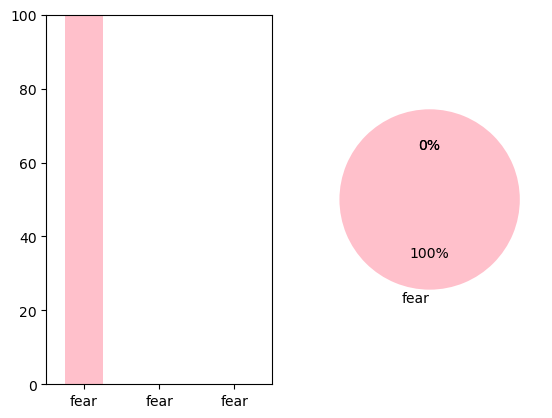

Audio Emotions
/home/chris/reesby/python/test_interviews/V4/spk_0_0.mp3


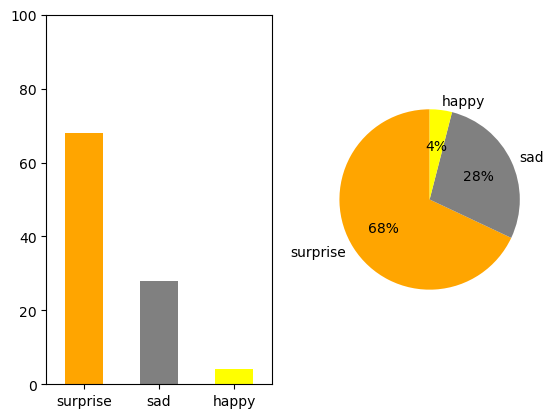

Video Emotions
/home/chris/reesby/python/test_interviews/V4/spk_0_1.mp4


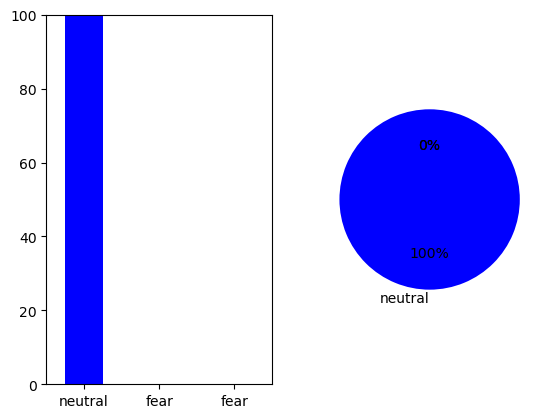

Audio Emotions
/home/chris/reesby/python/test_interviews/V4/spk_0_1.mp3


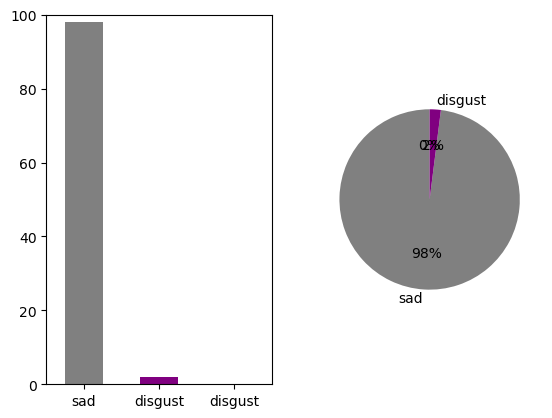

Video Emotions
/home/chris/reesby/python/test_interviews/V4/spk_0_2.mp4


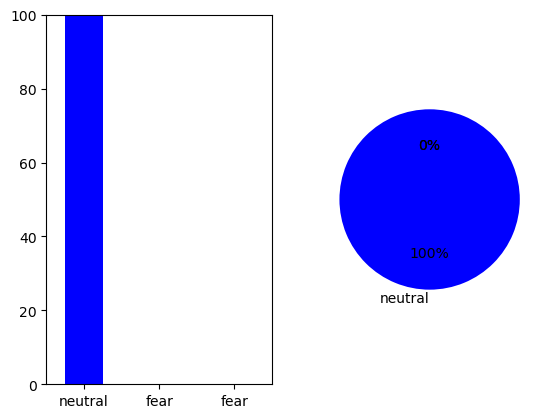

Audio Emotions
/home/chris/reesby/python/test_interviews/V4/spk_0_2.mp3


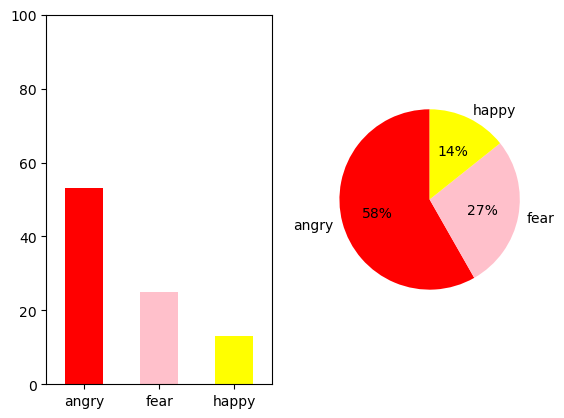

Video Emotions
/home/chris/reesby/python/test_interviews/V4/spk_0_3.mp4


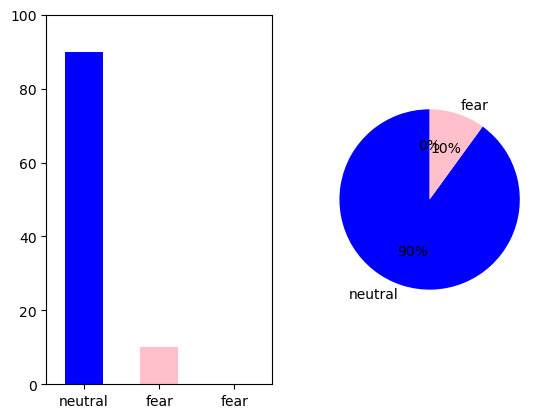

Audio Emotions
/home/chris/reesby/python/test_interviews/V4/spk_0_3.mp3


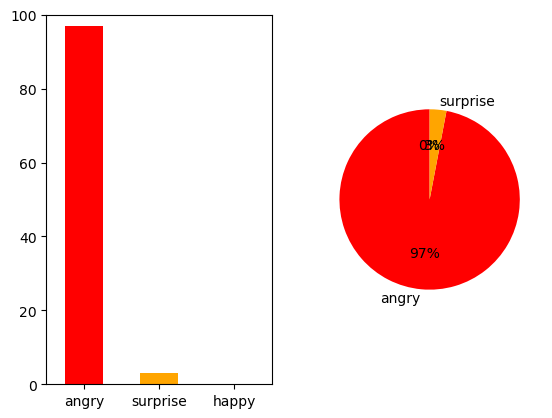

Video Emotions
/home/chris/reesby/python/test_interviews/V4/spk_0_4.mp4


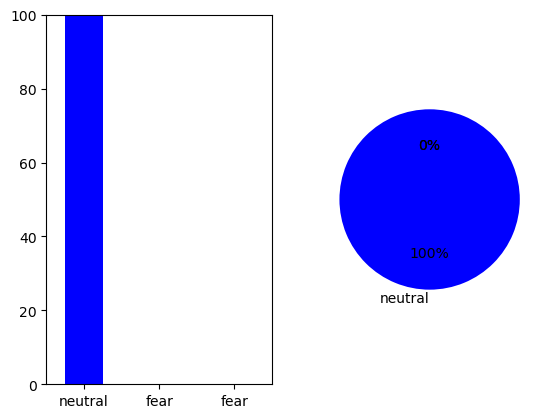

Audio Emotions
/home/chris/reesby/python/test_interviews/V4/spk_0_4.mp3


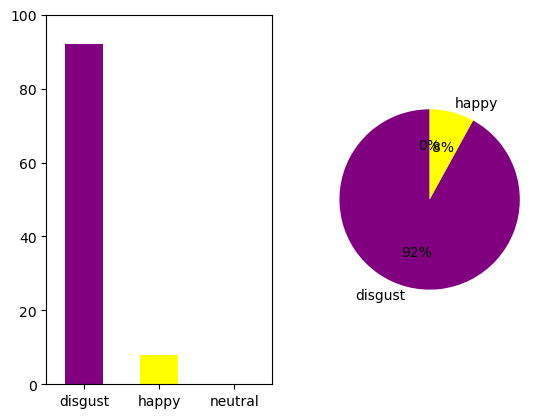

Video Emotions
/home/chris/reesby/python/test_interviews/V4/spk_0_5.mp4


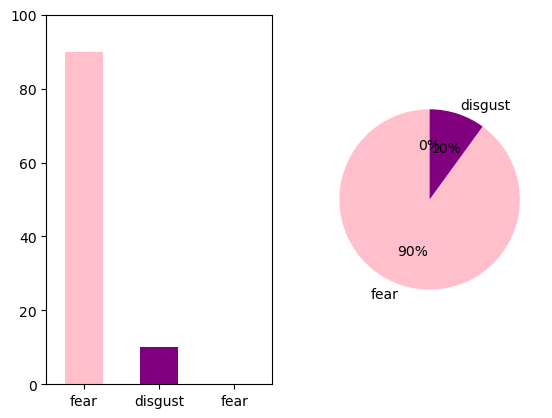

Audio Emotions
/home/chris/reesby/python/test_interviews/V4/spk_0_5.mp3


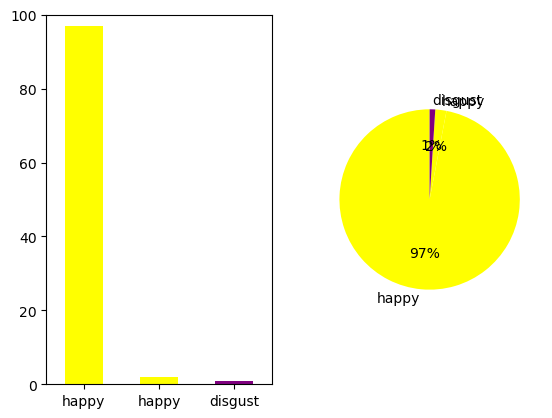

Video Emotions
/home/chris/reesby/python/test_interviews/V4/spk_0_6.mp4


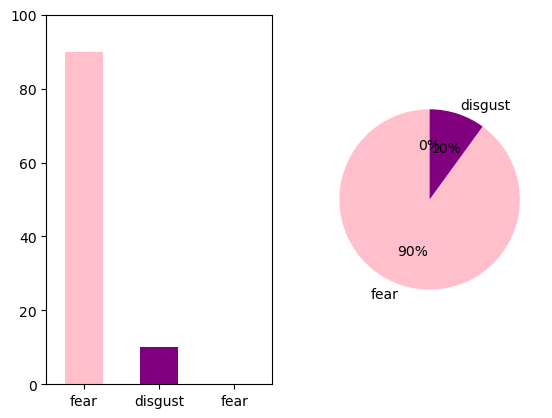

Audio Emotions
/home/chris/reesby/python/test_interviews/V4/spk_0_6.mp3


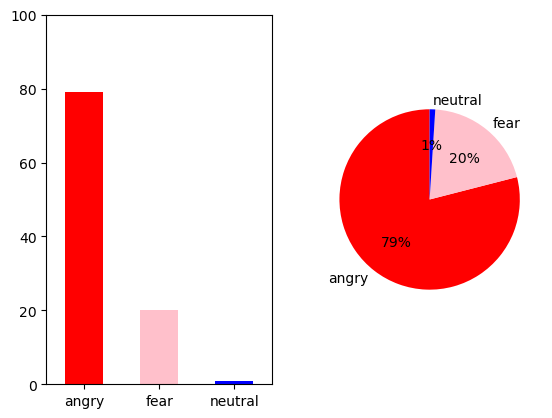

Video Emotions
/home/chris/reesby/python/test_interviews/V4/spk_0_9.mp4


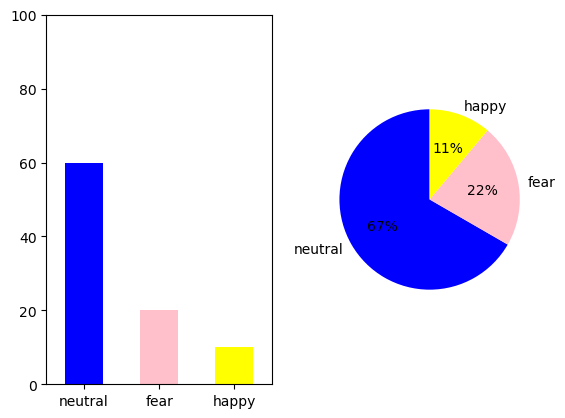

Audio Emotions
/home/chris/reesby/python/test_interviews/V4/spk_0_9.mp3


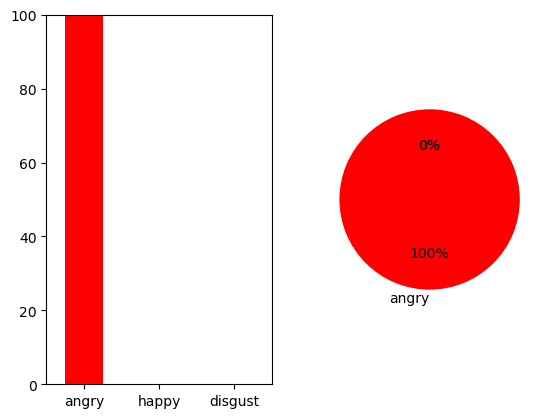

Video Emotions
/home/chris/reesby/python/test_interviews/V4/spk_0_10.mp4


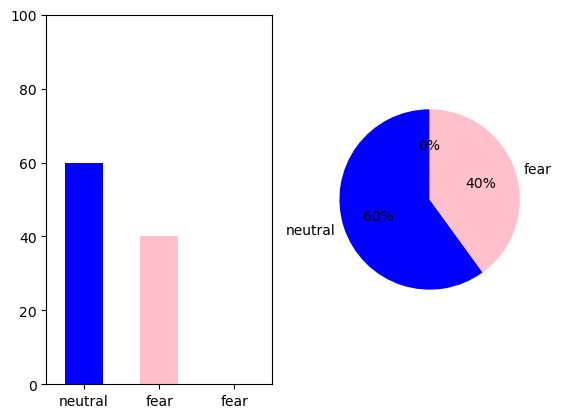

Audio Emotions
/home/chris/reesby/python/test_interviews/V4/spk_0_10.mp3


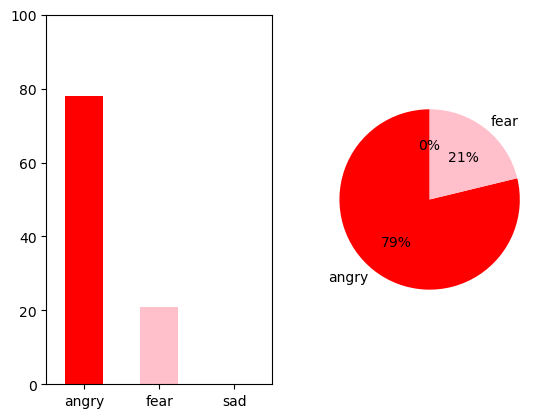

Video Emotions
/home/chris/reesby/python/test_interviews/V4/spk_0_7.mp4


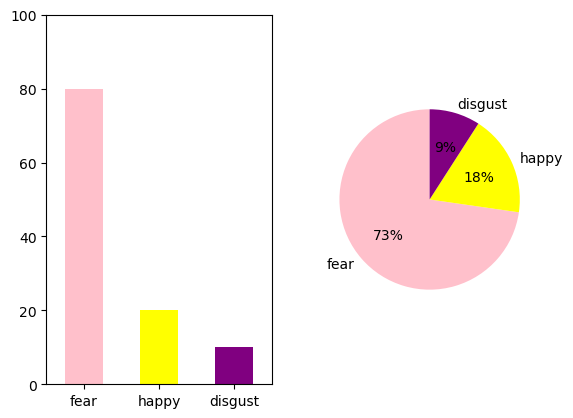

Audio Emotions
/home/chris/reesby/python/test_interviews/V4/spk_0_7.mp3


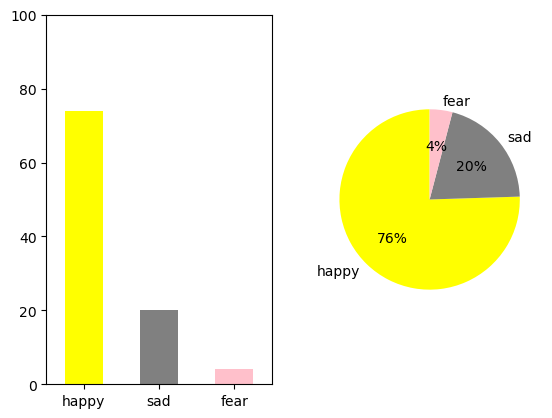

Video Emotions
/home/chris/reesby/python/test_interviews/V4/spk_0_11.mp4


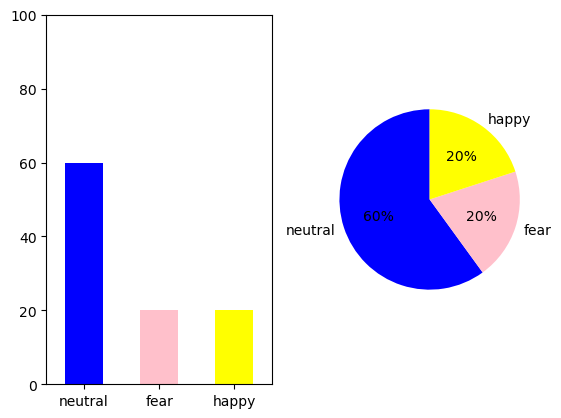

Audio Emotions
/home/chris/reesby/python/test_interviews/V4/spk_0_11.mp3


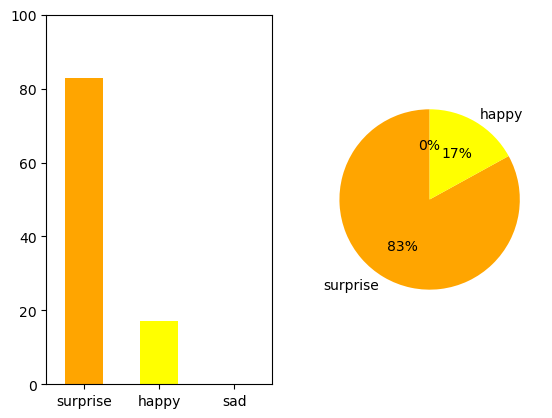

Video Emotions
/home/chris/reesby/python/test_interviews/V4/spk_0_8.mp4


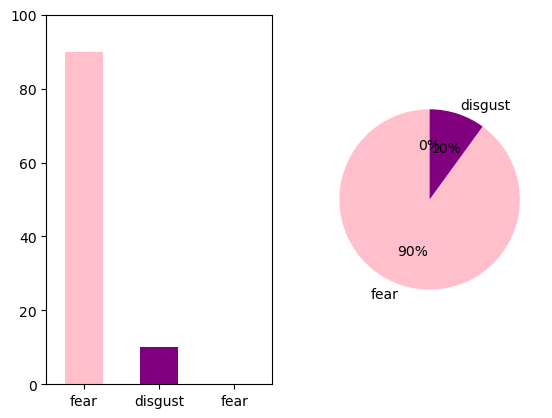

Audio Emotions
/home/chris/reesby/python/test_interviews/V4/spk_0_8.mp3


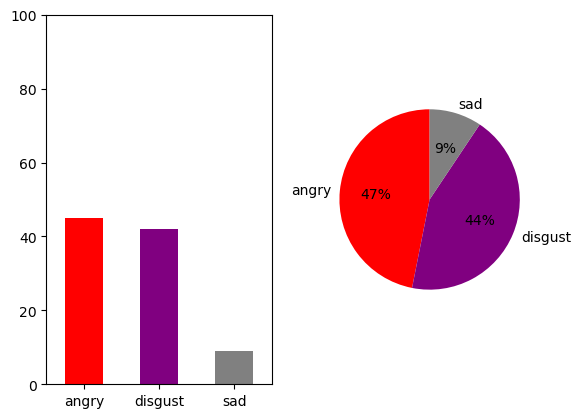

Video Emotions
/home/chris/reesby/python/test_interviews/V4/spk_0_12.mp4


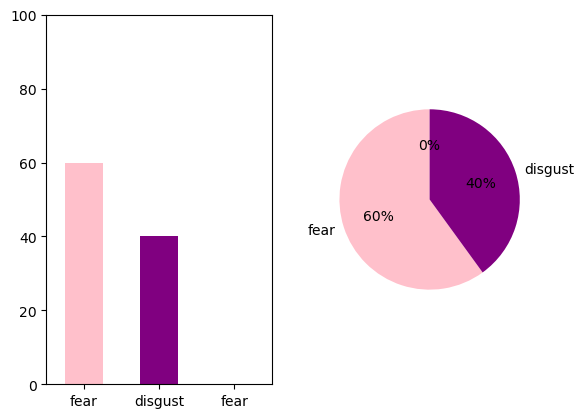

Audio Emotions
/home/chris/reesby/python/test_interviews/V4/spk_0_12.mp3


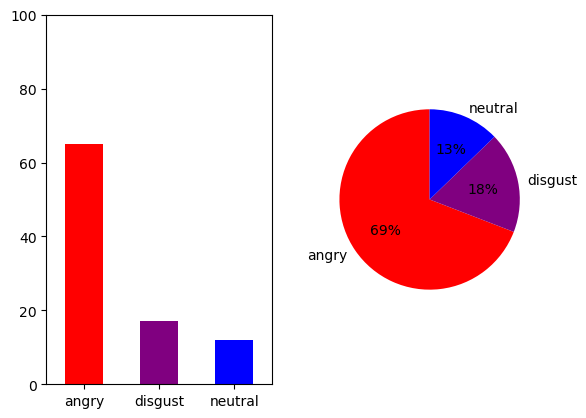


Threading Complete. We are at the end of the program. Combined final output is in V4_all_graphs.pdf


In [22]:
'''
Main driving function. Prompts for input json file. Output is new directory with audio/video split by speaker
and graphs for audio/video emotions and all_graphs combined in a pdf.
'''
if __name__ == '__main__':
    
    print("*****************************************************************************\n")
    print("This program will split up a video interview given the associated .json file")
    print("make sure the video file is in the same directory as the json file given")
    print("*****************************************************************************\n")
    
    #inp = input("Enter the json filename")
    inp = '/home/chris/reesby/python/test_interviews/asrOutput (5).json' #input("Enter the json filename")
    
    
    path, file = os.path.split(inp)
    print('path:',path,'\nfile:',file)

    interview_mp4 = read_output(inp)  
    print('\nThe interview file you should be using is : ' +interview_mp4+'.mp4')
    
    # the new directory will be names V1, V2, V* depending on the interview number
    new_dir = interview_mp4
    
    # make result directory with the label of the interview file
    print("\nResults to be stored in newly created "+interview_mp4+ " directory")
    
    # create the new path as the joining of the given path and 
    new_path = os.path.join(path,new_dir)
    print("\n new path    "+ new_path)
    
    if not os.path.isdir(new_path):
        os.mkdir(new_path)
    
    # filename for interview file is path and mp4 joined             
    mp4 = os.path.join(path,new_dir)+'.mp4'  #path+'/'+interview_mp4+'.mp4'
    print("\n mp4 file    "+ mp4)
    
    # decoded text from json file has been stored in file _times.txt so need to swap file name around
    decoded_text = path+'/'+file.replace('.json','_times.txt')
    print("\n decoded text   "+ decoded_text)
    
    # set up first thread to create the _times.txt file from the json file given             
    t1 = threading.Thread(target=read_output, args=(inp,))
    t1.start()
    t1.join()
    
    # next thread uses the _times.txt file to split up the video/audio by time.
    t2 = threading.Thread(target=audio_video_splitter, args=(new_dir,mp4,decoded_text))
    t2.start()
    t2.join()
    
    # next thread gets the emotions from the different audio/video files
    t3 = threading.Thread(target= get_Emotions, args=(new_path,))
    t3.start()
    t3.join()
    
    # final thread joins the emotion graphs into a pdf
    #t4 = threading.Thread(target=to_PDF, args=(interview_mp4,new_path))
    #t4.start()
    #t4.join()
                         
    print("\nThreading Complete. We are at the end of the program. Combined final output is in "+interview_mp4+"_all_graphs.pdf")